## Used to produce 'train_enriched.csv'

In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [293]:
train_df = pd.read_csv('../train.csv')


In [294]:
def hygiene(X, pct = 0.2):
    out = X.copy()
    drop_cols = []
    for col in out.columns:
        if out[col].isna().sum()/len(out) > pct:
            drop_cols.append(col)
    out = out.drop(columns=drop_cols)
    return out, drop_cols

In [295]:
train_df_hygiene, dropped_cols = hygiene(train_df, pct=0.2)

In [296]:
train_df_imputed = train_df_hygiene.dropna().reset_index(drop=True)
train_df_imputed

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V2,V3,V4,V5,V6,V7,V8,forward_returns,risk_free_rate,market_forward_excess_returns
0,1784,0,0,0,1,0,0,0,0,0,...,0.865079,0.757275,0.995370,-0.788270,0.000661,1.159223,0.000661,0.007186,0.000199,0.006674
1,1785,0,0,0,1,0,-1,0,0,0,...,0.837963,0.378968,0.992063,-0.667685,0.000661,0.888961,0.000661,-0.013873,0.000199,-0.014385
2,1786,0,0,0,1,0,-1,0,0,0,...,0.809524,0.921958,0.980159,-0.394297,0.000661,1.415329,0.000661,-0.012862,0.000199,-0.013374
3,1787,0,0,0,1,0,-1,0,0,0,...,0.832672,0.578704,0.988757,-0.472591,0.000661,1.744317,0.000661,-0.002850,0.000199,-0.003362
4,1788,0,0,0,1,0,-1,0,0,0,...,0.794974,0.900794,0.962963,-0.950978,0.000661,2.062731,0.000661,0.002858,0.000200,0.002344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7201,8985,0,0,0,0,0,0,0,0,0,...,0.785053,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,0.002457,0.000155,0.001990
7202,8986,0,0,0,0,0,0,0,0,0,...,0.767857,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,0.002312,0.000156,0.001845
7203,8987,0,0,1,0,0,0,0,0,0,...,0.734127,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,0.002891,0.000156,0.002424
7204,8988,0,0,0,0,0,0,0,0,0,...,0.695106,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,0.008310,0.000156,0.007843


In [297]:
# Firtsly create lagged target
train_df_imputed['lagged_forward_returns'] = train_df_imputed['forward_returns'].shift(1)
train_df_imputed['forward_returns_lag5'] = train_df_imputed['lagged_forward_returns'].shift(4)
train_df_imputed['forward_returns_win5_mean'] = train_df_imputed['lagged_forward_returns'].rolling(window=5).mean()
train_df_imputed['forward_returns_win5_std'] = train_df_imputed['lagged_forward_returns'].rolling(window=5).std()


In [298]:
class FeatureEnricher:
    """
    Enriches time series data with lags, rolling stats, time-based features, and transformations.
    """
    def __init__(self, 
                 lags=[1, 2, 5, 10], 
                 rolling_windows=[5, 10, 20], 
                 add_lags=True,
                 add_rolling=True,
                 add_diff=False,
                 add_pct_change=False):
        """
        Parameters
        ----------
        lags : list[int]
            List of lag periods to include.
        rolling_windows : list[int]
            List of window sizes for rolling statistics.
        use_cyclical_time : bool
            Whether to add cyclical time features (sin/cos of day/month).
        add_diff : bool
            Whether to include first differences.
        add_pct_change : bool
            Whether to include percent change.
        """
        self.lags = lags
        self.rolling_windows = rolling_windows
        self.add_lags = add_lags
        self.add_rolling = add_rolling
        self.add_diff = add_diff
        self.add_pct_change = add_pct_change
    def add_lags_features(self, df, col):
        """
        col : list[str]
        """
        lag_features = {
            f"{col}_lag{lag}": df[col].shift(lag)
            for lag in self.lags
        }
        return pd.DataFrame(lag_features, index=df.index)
    
    def add_rolling_features(self, df, col):
        roll_features = {}
        for w in self.rolling_windows:
            roll_features[f"{col}_roll_mean_{w}"] = df[col].rolling(w).mean()
            roll_features[f"{col}_roll_std_{w}"] = df[col].rolling(w).std()
        return pd.DataFrame(roll_features, index=df.index)
    
    def add_differences_features(self, df, col):
        diff_features = {}
        if self.add_diff:
            diff_features[f"{col}_diff1"] = df[col].diff(1)
        if self.add_pct_change:
            diff_features[f"{col}_pctchg"] = df[col].pct_change()
        return pd.DataFrame(diff_features, index=df.index)
    
    def transform(self, df, target_cols):
        """
        target_cols : list[str]
            Feature columns to enrich
        """
        df = df.copy()
        feature_frames = [df[target_cols]]
        for col in target_cols:
            if self.add_lags:
                feature_frames.append(self.add_lags_features(df, col))
            if self.add_rolling:
                feature_frames.append(self.add_rolling_features(df, col))
            feature_frames.append(self.add_differences_features(df, col))
            
        result = pd.concat(feature_frames, axis=1)
        # Drop rows with NaNs introduced by shifting/rolling
        result = result.dropna()
        return result

In [299]:
def enrich_data(df, features):
    ts_enricher = FeatureEnricher(lags=[1, 5], 
                              rolling_windows=[5, 20],
                              add_pct_change=True)   
    df_to_merge = ts_enricher.transform(df, features)    
    df_enriched = pd.merge(
    df_to_merge,
    df.drop(columns=features),
    left_index=True,
    right_index=True,
    how='inner').reset_index(drop=True)
    return df_enriched

In [300]:
dummy_features = [col for col in train_df_imputed.columns if col[0] == 'D']
standard_features = [col for col in train_df_imputed.columns if col[0] in ['E','I','M','P','S','V']]
features = standard_features + dummy_features

In [301]:
df_enriched = enrich_data(train_df_imputed, standard_features).dropna().reset_index(drop=True)
df_enriched

,E1,E10,E11,E12,E13,E14,E15,E16,E17,E18,...,D7,D8,D9,forward_returns,risk_free_rate,market_forward_excess_returns,lagged_forward_returns,forward_returns_lag5,forward_returns_win5_mean,forward_returns_win5_std
0,2.376776,0.999669,0.019511,0.006944,0.006944,0.006944,0.000661,0.360928,0.527039,-0.065329,...,0,0,0,-0.006680,0.000197,-0.007189,0.008468,0.011549,0.008551,0.006399
1,2.371209,1.000000,0.019180,0.006614,0.006614,0.006614,0.061839,0.359763,0.526098,-0.065417,...,0,0,0,-0.012103,0.000197,-0.012613,-0.006680,0.014173,0.004905,0.008949
2,2.365675,0.979167,0.018849,0.006283,0.006283,0.006283,0.061508,0.358596,0.525157,-0.065506,...,0,0,0,0.000388,0.000196,-0.000121,-0.012103,0.010870,-0.000350,0.009819
3,2.360173,0.979497,0.018519,0.005952,0.005952,0.005952,0.061177,0.357427,0.524216,-0.065594,...,0,0,0,0.011858,0.000196,0.011349,0.000388,-0.002304,-0.002446,0.007719
4,2.354703,0.979828,0.018188,0.005622,0.005622,0.005622,0.060847,0.356256,0.523277,-0.065683,...,0,0,0,0.000768,0.000197,0.000258,0.011858,0.008468,0.000386,0.010035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7182,1.565379,0.184524,0.019180,0.019180,0.005952,0.005952,0.911376,-0.083496,-0.572447,0.223638,...,0,0,0,0.002457,0.000155,0.001990,-0.002896,-0.005964,-0.000499,0.007015
7183,1.562946,0.184193,0.018849,0.018849,0.005622,0.005622,0.911706,-0.083542,-0.572080,0.222910,...,0,0,0,0.002312,0.000156,0.001845,0.002457,-0.007410,0.001185,0.006355
7184,1.560520,0.183862,0.018519,0.018519,0.005291,0.005291,0.912037,-0.083874,-0.572016,0.222211,...,0,0,0,0.002891,0.000156,0.002424,0.002312,0.005420,0.003130,0.004183
7185,1.558102,0.183532,0.018188,0.018188,0.004960,0.004960,0.912368,-0.084206,-0.571952,0.221513,...,0,0,0,0.008310,0.000156,0.007843,0.002891,0.008357,0.002624,0.003986


In [302]:
df_enriched.to_csv("train_enriched.csv", index=False)

In [303]:
X = df_enriched.drop(columns=['forward_returns', 'market_forward_excess_returns', 'risk_free_rate', "D1"])

In [304]:
y_all = df_enriched[['forward_returns', 'market_forward_excess_returns', 'risk_free_rate']]
y = df_enriched['forward_returns']


In [305]:
X_test = X[-1000:]
y_test = y[-1000:]
X_train = X[:-1000]
y_train = y[:-1000]

In [306]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

In [307]:
from scipy.stats import spearmanr

In [308]:
def rank_features_by_correlation(X, y):
    corr_results = []
    for col in X.columns:
        corr, pval = spearmanr(X[col], y)
        if np.isnan(corr):
            corr = 0.0
        corr_results.append({
            'feature': col,
            'spearman_corr': corr,
            'p_value': pval,
            'abs_corr': abs(corr)
        })
    corr_df = pd.DataFrame(corr_results).sort_values(by='abs_corr', ascending=False).reset_index(drop=True)
    return corr_df

In [309]:
def ridge_train(X_train, y_train, alpha=1.0, k = 90):
    top_features = rank_features_by_correlation(X_train, y_train).head(k)['feature']
    X_train = X_train[top_features]
    y_train = y_train

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    return model, top_features


In [310]:
from sklearn.ensemble import RandomForestRegressor


In [311]:
def rf_train(X_train, y_train, n_estimators=100, max_depth=6, max_features=0.7, k=90):
    rf_for_fs = RandomForestRegressor(
        n_estimators=200,  
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    rf_for_fs.fit(X_train, y_train.values.ravel())
    importances = rf_for_fs.feature_importances_
    idx_sorted = np.argsort(importances)[::-1]   # descending
    top_features = X_train.columns[idx_sorted[:k]]
    X_train = X_train[top_features]

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=0.025,     # 2% of samples per leaf (robust)
        min_samples_split=0.015,
        max_features=max_features,
        bootstrap=True,
        n_jobs=-1, random_state=42
    )
    model.fit(X_train, y_train)
    return model, top_features

In [312]:
from scipy.stats import pearsonr

In [313]:
def hitrate(y_true, y_pred):
    hits = np.sign(y_true) == np.sign(y_pred)
    return np.mean(hits)

In [314]:
ridge_model, ridge_features = ridge_train(X_train, y_train, alpha=1.0, k=30)
scaler = StandardScaler()
ridge_pred = ridge_model.predict((X_test[ridge_features]-X_train[ridge_features].mean())/X_train[ridge_features].std())
rho, p = pearsonr(ridge_pred, y_test)
print(hitrate(y_test, ridge_pred), rho, p)

0.546 0.09969524456972219 0.00159639697050165


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [351]:
ridge_tr = ridge_model.predict((X_train[ridge_features]-X_train[ridge_features].mean())/X_train[ridge_features].std())
rho, p = pearsonr(ridge_tr, y_train)
print(hitrate(y_train, ridge_tr), rho, p)

0.5411346371423953 0.1559600373770803 5.479576798291267e-35


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [315]:
rf_model, rf_features = rf_train(X_train, y_train, n_estimators=300, max_depth=6, max_features=0.3, k=80)
rf_pred = rf_model.predict(X_test[rf_features])
rho, p = pearsonr(rf_pred, y_test)
print(hitrate(y_test, rf_pred), rho, p)

0.48 0.029924739905236503 0.3444896556020274


In [316]:
ensemble_pred = 0.7 * ridge_pred + 0.3 * rf_pred
rho, p = pearsonr(ensemble_pred, y_test)
print(hitrate(y_test, ensemble_pred), rho, p)

0.533 0.09406328829578822 0.0029068013292487967


In [317]:
raw = pd.read_csv('../train.csv')

In [318]:
raw['lagged_forward_returns'] = raw['forward_returns'].shift(1)
raw['lagged_market_forward_excess_returns'] = raw['market_forward_excess_returns'].shift(1)
raw['lagged_risk_free_rate'] = raw['risk_free_rate'].shift(1)
X_raw = raw.drop(columns=['forward_returns', 'market_forward_excess_returns', 'risk_free_rate'])
X_raw_test = X_raw[-1000:]



In [319]:
X_raw_test

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,lagged_forward_returns,lagged_market_forward_excess_returns,lagged_risk_free_rate
7990,7990,0,0,0,0,0,0,0,0,0,...,0.867063,0.970238,2.055995,0.374339,0.353567,0.696098,0.461544,-0.009741,-0.010050,1.190476e-06
7991,7991,0,0,0,0,0,0,0,0,0,...,0.880291,0.970899,1.722448,0.475529,0.949781,0.718915,0.901332,-0.016674,-0.016983,1.111111e-06
7992,7992,1,1,0,0,0,-1,0,0,0,...,0.771825,0.970899,0.937120,0.396164,0.785138,0.676918,0.772232,-0.000945,-0.001253,9.920635e-07
7993,7993,0,0,0,0,0,-1,0,0,0,...,0.878307,0.968254,0.779079,0.275794,0.360145,0.709656,0.436983,0.009755,0.009447,7.936508e-07
7994,7994,0,0,0,0,0,-1,0,0,0,...,0.643519,0.928571,1.186779,0.171296,0.087732,0.697751,0.204552,0.012150,0.011842,9.920635e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,8985,0,0,0,0,0,0,0,0,0,...,0.469577,0.837963,1.226772,0.822751,-0.707361,0.142857,-0.649616,-0.002896,-0.003365,1.586508e-04
8986,8986,0,0,0,0,0,0,0,0,0,...,0.671958,0.837963,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.002457,0.001990,1.551587e-04
8987,8987,0,0,1,0,0,0,0,0,0,...,0.481481,0.787698,0.834898,0.823413,-0.723949,0.133929,-0.670946,0.002312,0.001845,1.558730e-04
8988,8988,0,0,0,0,0,0,0,0,0,...,0.655423,0.783730,0.994026,0.851852,-0.684937,0.101852,-0.646265,0.002891,0.002424,1.564683e-04


In [320]:
def predict(test: pd.DataFrame) -> float:
    X_test = test.copy()
    global X_raw_rolling
    global rf_model
    global ridge_model
    global ridge_features
    global rf_features
    global dropped_cols
    global mean
    global std
    X_raw_rolling = pd.concat([X_raw_rolling,X_test], ignore_index = True)
    
    # Firtsly create lagged target
    X_enriched_rolling = X_raw_rolling.copy()

    X_enriched_rolling['forward_returns_lag5'] = X_enriched_rolling['lagged_forward_returns'].shift(4)
    X_enriched_rolling['forward_returns_win5_mean'] = X_enriched_rolling['lagged_forward_returns'].rolling(window=5).mean()
    X_enriched_rolling['forward_returns_win5_std'] = X_enriched_rolling['lagged_forward_returns'].rolling(window=5).std()
    X_enriched_rolling = X_enriched_rolling.drop(columns=dropped_cols)
    dummy_features = [col for col in X_enriched_rolling.columns if col[0] == 'D']
    standard_features = [col for col in X_enriched_rolling.columns if col[0] in ['E','I','M','P','S','V']]
    features = standard_features + dummy_features
    X_enriched_rolling = enrich_data(X_enriched_rolling, standard_features).reset_index(drop=True)
    X_test = X_enriched_rolling.iloc[-1:]
    ridge_pred = ridge_model.predict((X_test[ridge_features]-mean[ridge_features])/std[ridge_features])[-1]
    rf_pred = rf_model.predict(X_test[rf_features])[-1]
    mean_pred = ridge_pred*0.7 + rf_pred*0.3
    std_estimate = X_test['forward_returns_win5_std'].iloc[-1]
    risk_free_estimate = X_test['lagged_risk_free_rate'].iloc[-1]
    allocation = (12*(mean_pred - risk_free_estimate) /std_estimate).clip(min=0.0, max=2.0)
    return allocation, mean_pred, ridge_pred, rf_pred

    

   

In [321]:
ridge_pred[0], rf_pred[0]

(np.float64(0.00141661999439103), np.float64(0.0005874908374293287))

In [322]:
X_test['date_id']

6187    7990
6188    7991
6189    7992
6190    7993
6191    7994
        ... 
7182    8985
7183    8986
7184    8987
7185    8988
7186    8989
Name: date_id, Length: 1000, dtype: int64

In [323]:
X_raw_rolling = X_raw[-1000-50:-1000]
mean = X_train.mean()
std = X_train.std()
positions = []
predicted_returns = []
ridge_mean_list = []
rf_mean_list = []
for i in range (len(y_test)):
    print(i)
    w, pred_return, ridge_mean, rf_mean = predict(X_raw_test.iloc[i:i+1])
    print(w)
    positions.append(w)
    predicted_returns.append(pred_return)
    ridge_mean_list.append(ridge_mean)
    rf_mean_list.append(rf_mean)

0
1.999594793659796
1
2.0
2


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.452132620590035
3
1.645288552809487
4


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4567422493687357
5
0.7972126979792074
6
1.6274959744907875
7
1.0859164728025574
8


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1645803044691159
9
1.9654511374712527
10
1.5900220090505084
11
1.2917793828435722
12


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0934361856646655
13
1.3431288296655026
14
0.9968585813138159
15
0.9143698077717448
16


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.694195631527748
17
1.8478307513723111
18
1.624019303633789
19
0.151930653408319
20


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
21
0.06542369153894703
22


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.2638991853798491
23
0.0
24
0.0
25
1.0944344833015331
26


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.6439710900037503
27
0.16771704861339345
28
0.0
29
0.0
30


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
31
0.761476175638055
32
0.6753206926417734
33
0.3685293009957917
34


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8913530818819849
35
1.1416296822614287
36
0.0
37
0.0
38


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.9541882048473077
39
1.1234554833198571
40
1.1242231110005607
41


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
42
0.0
43
1.1542860752733581
44
0.6460965360990061
45


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
46
0.0
47
0.0
48
0.0
49


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.084016262130748
50
0.0
51
0.9684326420172195
52
1.5698999229906343
53


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.30857733061645287
54
1.0912333209958924
55
0.5226424931448116
56
0.0
57


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.00021146459686667785
58
0.37731140232654475
59
0.0
60
0.26498002897937484
61


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.12009090091563805
62
0.18648942449598216
63
0.031969422417242994
64
1.329530668424128
65


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
66
0.9560438352443487
67
0.9315704369122039
68
0.57392968123731
69


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.11223519208217703
70
0.0
71
0.0
72
0.0
73


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
74
0.45488253032217835
75
0.0
76


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.20829065149413614
77
0.8537740274791259
78
2.0
79
2.0
80


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1651017425954808
81
1.1025439267060524
82
0.5255701338373363
83
0.7533435883833131
84


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0393604516777313
85
1.1786929034038132
86
1.8121684667223463
87
1.471695910075221
88


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8367955189911357
89
2.0
90
2.0
91
2.0
92
1.12525735447862
93
0.23196863479965163
94
0.0
95


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
96
0.0
97
0.14259366710110263
98
0.5006452065226834
99


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.5284246676186631
100
0.42396684803513124
101


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.9754581288748595
102
1.4573885485284097
103
1.5189054335088865
104
0.6777871913824273
105


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0882938154730777
106
1.4844197234899064
107
1.1417555941227922
108
1.6272132339246699
109


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
110
1.949175721652666
111
0.5803922210920986
112


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8287391906608353
113
1.0517388426269565
114
0.0
115


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.49407875860134476
116
1.6318633959651645
117
1.716959263568407
118
0.33031161274295096
119


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.5977750421482093
120
0.6068124810746315
121


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1950664518925112
122
1.6228552944728125
123
0.6018659786119831
124
0.0
125


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
126
0.0
127
0.0
128
0.0
129


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
130
0.0
131
0.2734397699794769
132
0.0
133


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.32336930557283355
134
0.586194876865479
135
1.7924610845733102
136
1.82353491454117
137


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.6275895975439805
138
1.9632113780608236
139


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.9009855324860188
140
1.9218517405994657
141
2.0
142
2.0
143


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
144
1.263098720622209
145
1.7751044868176935
146
1.363530312364781
147


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6795386827622018
148
0.652442588639728
149
0.9859166677545513
150
1.2296314731997915
151


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.22635093782478163
152
2.0
153
0.867853656165622
154
0.713939830837049
155


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.4530439017545986
156
1.1977785323471788
157
0.7728183204557423
158
0.21006908348819386
159


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.996449960870822
160
0.37765483225466884
161
0.8174392735749225
162
0.03965956362088793
163


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.981060795608708
164
2.0
165
1.7330690605190746
166
2.0
167


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0174001858433226
168
1.1245442175529523
169
0.2704571034555636
170
0.6706158488648174
171


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
172
0.6815085762256473
173
0.0
174


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.09886421679504792
175
0.0
176
0.381018090646171
177
0.12434213004501109
178


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
179
0.0
180
0.0
181
0.0
182


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
183
0.8413783928424662
184
1.4730410417737698
185
1.9465831043337876
186


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.2274176157196461
187
0.12592639692263188
188
1.1615885648196025
189
0.5226489097717697
190


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.2173671271010826
191
0.0
192
0.28063637507956163
193
0.0
194


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
195
0.03308193388185643
196
0.16297532858629754
197
0.7466840931039457
198


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.6509084892149504
199
1.696702781471542
200
1.7979726531854805
201
1.6786802244805987
202


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
203
2.0
204
2.0
205
2.0
206


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
207
1.3436984698867451
208
1.4692267673061918
209
0.1385992928887817
210


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
211
0.0
212
0.0
213


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
214
0.0
215
0.0
216


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
217
0.0
218


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
219
0.0
220
0.0
221
0.0
222


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
223
0.0
224
0.0
225
0.39742991796138755
226


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4048096021079679
227
0.7806049207691215
228
0.974793717996527
229
0.0
230


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
231
0.0
232
0.0
233
0.39986032625601053
234


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.56593551586123
235
0.6055288164465611
236
0.31978485421622505
237
1.1118195961234802
238


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8241952787136255
239
0.9756945599331164
240
1.0773004409995846
241


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.5440706624000655
242
2.0
243
2.0
244
0.7307491267887531
245


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7372682977583391
246
0.0
247
0.0
248
0.2165079815523758
249


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
250
0.29000515015549316
251
0.9806296941407918
252
1.8968228064334562
253


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
254
2.0
255
2.0
256
2.0
257


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
258
2.0
259


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8510038545366972
260
0.81591457186598
261
1.269633402933207
262
0.2561881704006583
263


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
264
0.0
265
0.0
266
0.0
267


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
268
0.39134983402246076
269
0.8395662651557289
270
0.0
271


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.07892169256926261
272
0.0
273
0.0
274
0.0
275


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
276
0.0
277


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
278
0.0
279
0.0
280
0.0
281


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
282
0.0
283
0.0
284
1.011320513471426
285


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.778047503346396
286
2.0
287
0.9344973053930417
288
0.7760033123962854
289


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.819168849778051
290
0.3025336967360184
291
0.0
292
0.22804492346309818
293
0.10092706188373618
294
0.0
295
0.0
296


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
297
0.0
298


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7465139780598691
299
0.5676956453904282
300
0.0
301
0.4284425156973246
302


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6491111981042068
303
0.0
304
0.0
305
0.0
306


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
307
0.0
308
0.5289390788127996
309
0.0
310


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6079303964329893
311
0.23977024505059724
312
1.1339822480688166
313
0.0
314


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.12634510401336999
315
1.295538695657591
316
1.9013830559867404
317


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.8132468319409998
318
0.49699691574742977
319
0.948182325697666
320
1.3756357116211544
321


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
322
1.8628393225542283
323
1.3201678465942714
324
1.0610597906865535
325


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7971699095546622
326
0.1949842991467229
327
0.7423410760471959
328
0.5326831523660293
329


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.17827599535840294
330
0.0
331
0.0
332
0.0
333


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
334
0.0
335
0.35320500707498714
336


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7427473088201902
337
0.1717827173206082
338
0.0
339
1.906471383575847
340


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1753178952138732
341
0.0
342
0.0
343
0.0
344


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
345
0.0
346
0.0
347
0.0
348


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
349
0.0
350
0.0
351
0.1400824915179785
352
0.12612078048597075
353
0.25321801858479936
354
0.0
355


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
356
1.0850899542698098
357


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1585999000022664
358
1.9379264951153445
359
1.1658756611119139
360
0.784004258111732
361


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.4127349606522694
362
0.9820311188897008
363
1.6125718428932507
364
2.0
365


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.2854767908376774
366
0.0
367
0.0
368
0.0
369


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
370
0.0
371
0.47609233440404886
372
0.36759603751716624
373


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
374
0.9273367649460772
375
0.0
376


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.27803103762966697
377
0.0
378
0.0
379


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.1825226103013814
380
0.15314932324779945
381
0.0
382
0.2878317172278217
383


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.49104271989024545
384
0.2294097451170347
385
0.6109343479484937
386


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.16059200299368068
387
0.0
388
0.0
389
0.5558103634988567
390


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.26639669140510264
391
0.9146070859236292
392
0.06809775129502899
393


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.8046168017733688
394
0.4840882993209634
395


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4299799238255824
396
0.7167632458806859
397
0.6048610611770224
398
0.0
399


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.9757473677599727
400
0.2968240845518923
401
1.051363822479133
402
0.8400403356136316
403


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7251651985026534
404
0.0
405
0.0
406
0.0
407


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
408
0.20351640274572705
409
0.12819960238559988
410
0.0
411
0.0
412
0.0
413


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
414
0.0
415


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.104307756658793
416
0.3883629751783831
417
0.2140869990717836
418


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
419
0.0
420
0.0
421


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
422
0.0
423
0.0
424


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
425
0.0
426
0.0
427


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
428
0.0
429
0.0
430


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
431
0.0
432
0.0
433


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
434
0.0
435


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
436
0.0
437
0.0
438


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
439
0.0
440
0.4333335574526633
441


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8587158289706924
442
0.0
443


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7178257944794276
444
0.42760123759012486
445
0.0
446


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
447
0.19070628662426012
448
0.0
449


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
450
0.0
451
0.0
452


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
453
0.0
454


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
455
0.0
456
0.0
457


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
458
0.0
459
0.0
460
0.0
461


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
462
0.0
463
0.0
464
0.0
465
0.0
466
0.0
467


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
468
0.0
469
0.0
470
0.05868947512879035
471


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.21680359196317273
472
0.3135438379796403
473
0.209178117384012
474


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.48863917959759684
475
0.8508296997377203
476
0.7389232412691311
477


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6722101832973632
478
0.21011053245061279
479
0.4830047429373526
480


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.45302067690178355
481
0.712657405496946
482
0.707833839643911
483


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8370609659819719
484
1.1098705916577634
485
0.9165524761707119
486


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8204302224361704
487
0.0
488
0.6518504906108537
489


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.07919285201000975
490
0.2264884130391355
491
0.0
492


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3591459679455517
493
0.038202323475595636
494


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.8108803841693475
495
2.0
496
2.0
497


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.7221450718439604
498
1.2233638963884403
499
2.0
500
1.436424241779753
501
0.935692575727488
502
0.9593465402118253
503


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6509901932279617
504
0.8868671299311444
505
1.7750163727133939
506


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.512360155214224
507
1.4440968193421038
508
2.0
509


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.6561713256045465
510
1.1615603510240156
511
1.0189031984435002
512


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.4764286279183771
513
1.0958161726678368
514


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.565482947307312
515
0.9660506291085059
516
0.3841897274238554
517


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.002748209755929292
518
0.0
519
0.0
520


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.24825808277312342
521
0.308247143784457
522
0.0
523


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.031111745480230983
524
0.5299451245745224
525
0.6625783851788503
526


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8610274494165179
527
2.0
528
1.8983285611242442
529


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
530
2.0
531
2.0
532


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.4830986976630531
533
1.1813230983437406
534


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4629204107439605
535
0.0
536
0.0
537


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
538
0.0
539
0.0
540


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.5775400809791804
541
0.8347392443762252
542
0.22371917729708707
543


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3498840596227335
544
0.6717980068780427
545
0.7271516400729894
546


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8767418434997811
547
0.0
548
0.0
549


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
550
0.0
551
0.0
552


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
553
0.0
554


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
555
0.0
556
0.09537494492958601
557


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3404442992560699
558
0.7388603533217337
559
0.0
560


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3328260036045709
561
0.0
562
0.0
563


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
564
0.0
565
0.21518650721816138
566


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7933468324101965
567
0.0
568
0.0
569


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
570
0.20624881987155974
571
0.0
572


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.21661877500129456
573
0.3258619254510803
574
2.0
575


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.228432350465476
576
1.7539444923099872
577
2.0
578


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
579
1.3513426632017926
580
0.8692906131748025
581


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7559326523780209
582
0.7031428172519415
583
0.7819084236253192
584


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8246941222726357
585
1.1219325248484815
586
0.45205315664534335
587


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.37178753911855
588
0.2336041611164893
589
0.6451324025303918
590


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0299369177434397
591
0.0
592


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
593
0.0
594
0.0
595


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.1098766768416868
596
0.4835940583031073
597
0.2344052277434832
598


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.20450963566983835
599
0.7519597023914909
600
0.31370138223075755
601


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
602
0.8175346258048324
603
0.0
604


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.1412800600771434
605
1.208663873714352
606
0.14909172976776705
607


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3375046509243473
608
1.12978494704975
609
1.37302999736125
610


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
611
0.0
612


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.243665681023321
613
0.3590534315795059
614
0.14802060182159069
615


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
616
0.0
617
1.8649984677169436
618


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.5435041245511423
619
1.9688960660469867
620
0.0
621


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
622
0.40727705777820655
623
0.25579299327330046
624


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
625
0.0
626
0.5210501814458478
627


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.2775620424173556
628
0.0
629
0.0
630


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
631
0.0
632


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.1569807153138507
633
0.0
634
0.0
635


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
636
0.0
637
0.5866441613477583
638


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
639
0.09816097013313085
640
0.37468188652052836
641


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.36438408064963573
642
0.1901244375067595
643
0.21201964724029168
644


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
645
0.4079533066878073
646
0.7808969562253293
647


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0403369928630868
648
1.1581652052023332
649
2.0
650


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
651
1.6569523504307333
652


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.2128540496921056
653
0.5232872552251323
654
0.9388229894288662
655


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
656
0.0
657
0.19301145973475897
658


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7459762749003512
659
0.6525286798178727
660
0.3364723920874207
661


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4460193745659319
662
0.0
663
0.0
664


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.452172450405223
665
0.02428175214645953
666
0.0
667


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.45392569064717175
668
0.32224977723986375
669
0.0
670


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7821522895011426
671
0.91283284486995
672
0.0
673


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8927950912346879
674
0.144593968912743
675
0.0
676


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
677
0.0
678
0.4362699834175715
679


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3703983019864557
680
0.4154848621879763
681
0.20607212439602693
682


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
683
0.0
684
0.0
685


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
686
0.0
687
0.0
688


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
689
0.0
690


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
691
0.0
692
0.0
693


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
694
0.46760820761184846
695
0.0
696


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.029832311890238494
697
0.0
698
0.018916492226959958
699


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0764867243694065
700
0.8350027806922525
701
0.0
702


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
703
0.0
704
0.0
705


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
706
0.0
707
0.1234878210667238
708


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.08671515106165359
709
0.0033717939983170745
710


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4112604106293284
711
1.0025243626380638
712
1.3582271143102616
713


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8687179229934968
714
0.0
715
0.4082236796616304
716


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.9264057336452671
717
0.5473756936772907
718
0.33224680236420145
719


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7095217053271731
720
0.0
721
0.0
722


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4889480982653551
723
1.911612626959498
724
0.0
725


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.2727284038621272
726
0.6307303242473431
727
0.6933178755790257
728


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6913733904720494
729
0.4121158997985598
730


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
731
0.0
732
0.0
733


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
734
0.0
735
0.0
736


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
737
0.5979503024036994
738
0.691964830368834
739


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.6571358413634556
740
1.6293738677614964
741
0.7986446368332509
742


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1661117924301332
743
0.0
744
0.5807672543152966
745


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3624746329245643
746
1.1819860897853942
747
0.7885141751511433
748


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4026241605343027
749
0.0
750


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.25972746775077155
751
0.0
752
0.0
753


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
754
0.0
755
0.0
756


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
757
0.0
758
0.0
759


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
760
0.6508055769139984
761
0.0
762


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
763
0.0
764
0.0
765


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.12713258616754147
766
0.0
767
0.16831547848050363
768


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
769
0.0
770
0.0
771


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.006597390400085837
772
0.0
773
0.0
774


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.12484850878474231
775
0.533316212590806
776
0.0
777


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
778
0.0
779
0.0
780


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
781
0.4315503747432066
782
0.030791814469932195
783


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.495569102807502
784
0.24431092092324372
785
0.3984549081802486
786


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.3708268255403675
787
0.4175877062512236
788


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.15937346622374712
789
0.0
790
0.0
791


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.11023716369042526
792
0.0
793
0.0
794


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
795
0.1543040790661145
796
1.2145315711099929
797


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0864842986449983
798
0.5840004334257443
799
0.3169925092829192
800


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.1974413487733144
801
0.0
802
1.1413153488373227
803


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1165703838293561
804
1.6549716539762698
805
0.0
806


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
807
0.0
808


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
809
0.0
810
0.0
811


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
812
0.8269126064974414
813
0.6784395578314508
814


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.2276492407312104
815
0.9574294879759286
816
0.4287138967762068
817


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
818
1.3990333916616597
819
0.0042351239499300005
820


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.576222758173535
821
0.7966524679682215
822
0.8830602688422412
823


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.38585396474135564
824
0.043160196827831884
825
0.5867659164497367
826


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7596335690115815
827
1.4582014042481282
828


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.754744463886101
829
0.2506794867295407
830
0.0
831


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
832
0.5422703400460174
833
0.7766410105899373
834


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0112445327616875
835
0.20840033203430422
836
0.04160443621359316
837


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
838
0.0
839
0.0
840


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
841
0.0
842
0.0
843


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
844
0.056053673375535656
845
0.6767875399638087
846


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6621420540162143
847
1.0926310005511795
848


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.5100054149211645
849
0.2926511067744063
850
0.5676929293544768
851


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.5677256419587007
852
0.27630855758064604
853
0.0
854


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
855
0.018649595208066676
856
0.0
857


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
858
0.0
859
0.0
860


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.33891422079599454
861
0.4162930410334791
862
0.9797540507445842
863


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0623658527514412
864
2.0
865
0.8038102300955876
866


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.064064296726969
867
1.3019398146578298
868


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.9337737110960815
869
0.9600268266622928
870
0.9319007605209485
871


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.4115386411210737
872
0.9822552210076703
873
1.7067585821701374
874


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.9605522344061974
875
1.2856089478244477
876
1.1985897189309334
877


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.078243347687043
878
0.6625356838148012
879
0.5530029212085967
880


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.9678232114046015
881
0.6097485271882308
882
0.0
883


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.4929787100373902
884
0.9733594153043205
885
1.3235822944561677
886


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.407910673254211
887
1.5743777987163274
888


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.4317369382479659
889
1.7225741903896032
890
2.0
891


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.28592807172924595
892
2.0
893
0.0
894


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.2025908996614496
895
0.0
896
0.0
897


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.1274049432484433
898
0.9651437069275224
899
0.10669897401975639
900


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.5294185767719781
901
0.0
902
0.1472218610746438
903


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.33977156987461066
904
0.6211633687504423
905
0.705030794079764
906


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
907
0.0
908


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
909
0.0
910
0.0
911


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.40047966219549813
912
0.06853922594030404
913
0.6768032516086191
914


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.2068856815427222
915
0.8876411146265184
916
0.7109059614460049
917


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6724209370455657
918
0.2630895902584745
919
0.0
920


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
921
0.0
922
0.0
923


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
924
0.9228975377162035
925
0.2189120465106175
926


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8746924789824725
927
1.0386585404100583
928


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.6854584824233994
929
0.0
930
0.0
931


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
932
0.0
933
0.0
934


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.3198910666713504
935
2.0
936
2.0
937


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.471865702927856
938
0.7215886502038826
939
0.0
940


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
941
0.7425455796141904
942
0.8106253253687551
943


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.8407310117356641
944
1.0090308331347426
945
1.0247297040248857
946


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1133437034391387
947
0.7508228686845891
948


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
949
0.13435808775053437
950
0.0
951


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
952
0.0
953
0.0
954


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
955
0.0
956
0.05499632480183319
957


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
958
0.0
959
1.579884341975213
960


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.3468264763488071
961
1.4616753604920014
962
1.7967675744312186
963


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.8204765114518688
964
0.11823355463536779
965
0.16338783296107548
966


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.8262477233313061
967
1.7027075735214912
968


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0013418479214116
969
2.0
970
2.0
971


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


2.0
972
1.5786712049549436
973
1.453286395997943
974


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.3782685655851172
975
1.3476926458034237
976
1.3596468259101022
977


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.7078536332892897
978
1.2254896784104086
979
0.6417903528593284
980


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.38564807240425714
981
0.9670539950234651
982
0.0
983


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.0383655548593111
984
2.0
985
2.0
986


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


1.1260898187307342
987
0.4767631362198511
988


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.7674951921308297
989
0.0
990
0.0
991


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.09218358359165366
992
0.13232516437646738
993
0.0
994


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


0.0
995
0.24653653844445297
996
0.7822546389924099
997
0.37182054981250556
998
0.11834171051105015
999
0.06462609907683133


/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
/Users/xingzheli/Documents/Python-WorkSpace/kaggle/kaggle_hull_tactic_2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [324]:
pearsonr(predicted_returns, ensemble_pred)

PearsonRResult(statistic=np.float64(0.9999999999999994), pvalue=np.float64(0.0))

In [325]:
def score(solution: pd.DataFrame, submission) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """

  
    solution = solution.copy()
    solution['position'] = submission

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()
    trading_days_per_yr = 252
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    print(sharpe)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
    market_std = solution['forward_returns'].std()


    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100
    print(strategy_mean_excess_return, market_mean_excess_return, strategy_volatility, market_volatility)
    print(return_penalty, vol_penalty)
    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

In [326]:
score(y_all[-1000:], [1.0]*len(y_test))

0.3959006764160921
0.00026942109543881543 0.00026942109543881543 17.14928013389517 17.14928013389517
1.0 1


0.3959006764160921

In [327]:
score(y_all[-1000:], [2.0]*len(y_test))    

0.3097275489985266
0.00042149335785923725 0.00026942109543881543 34.29347067252098 17.14928013389517
1.0 1.7997032181392092


0.17209923607224933

In [328]:
score(y_all[-1000:], positions)

1.0022575681298374
0.0006583939053013133 0.00026942109543881543 16.554154282468588 17.14928013389517
1.0 1


1.0022575681298374

In [330]:
pnl = y_test * positions

In [331]:
import matplotlib.pyplot as plt

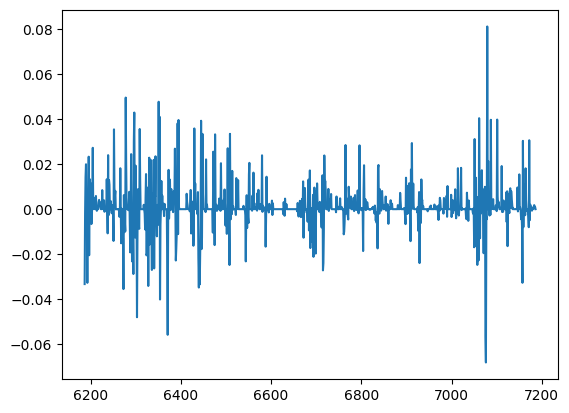

In [333]:
plt.plot(pnl)

In [337]:
sharpe = pnl.rolling(window=125).mean() / pnl.rolling(window=125).std() * np.sqrt(125)

In [348]:
baseline = y_all['forward_returns'][-1000:]

In [349]:
baseline_sharpe = baseline.rolling(window=125).mean() / baseline.rolling(window=125).std() * np.sqrt(125) 

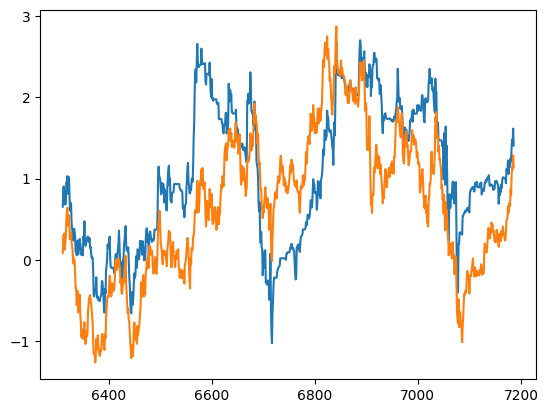

In [350]:
plt.plot(sharpe)
plt.plot(baseline_sharpe)